# Ross Sea sea ice dynamics
## Level sea ice freeboard & ridge height/fraction

In [109]:
import warnings
warnings.filterwarnings('ignore')

import os, glob
import csv
import numpy as np
# import icepyx as ipx
from os import listdir
from os.path import isfile, join
import h5py
import matplotlib.pylab as plt
from math import *
import random
# import time
import pandas as pd
from tqdm import tqdm
import pickle

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import datetime as dt
from shapely.geometry import Point
import geopandas
import scipy.stats as stats
import netCDF4
from netCDF4 import Dataset    # Note: python is case-sensitive!
from netCDF4 import date2num,num2date

from pyproj import Proj, transform
from shapely.geometry import Polygon
from sklearn.neighbors import KernelDensity

import utils as ut

from tqdm import tqdm
import matplotlib.ticker as mticker

# from mpl_toolkits.basemap import Basemap

%load_ext autoreload
%autoreload 2

from readers import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [105]:
for year in [2018, 2019, 2020, 2021, 2022]:

    try: ncfile.close()  # just to be safe, make sure dataset is not already open.
    except: pass
    
    with Dataset('D:\\Ross\\ATL10_processed_nc\\Ridges_density_{0}.nc'.format(year), mode='w') as ncfile:
        print(ncfile)

        xp = np.arange(-2000000, 1500001, 25000)
        yp = np.arange(-3200000, -800001, 25000)

        xx, yy = np.meshgrid(xp, yp)
        lats, lons = transform(Proj("EPSG:3412"), Proj("EPSG:4326"), xx, yy) 

        x_len = len(xp)
        y_len = len(yp)

        x_dim = ncfile.createDimension('x', x_len)     # latitude axis
        y_dim = ncfile.createDimension('y', y_len)    # longitude axis
        time_dim = ncfile.createDimension('time', None) # unlimited axis (can be appended to).
        for dim in ncfile.dimensions.items():
            print(dim)

        ## XY grid ================================================
        x = ncfile.createVariable('x', np.float32, ('x',))
        x.units = 'meters'
        x.long_name = 'Center_x_values'
        y = ncfile.createVariable('y', np.float32, ('y',))
        y.units = 'meters'
        y.long_name = 'Center_y_values'

        ## Time ================================================
        time = ncfile.createVariable('time', np.float64, ('time',))
        time.units = 'hours since 1800-01-01'
        time.long_name = 'time'

        ## latitude & longitude ================================================
        lat = ncfile.createVariable('lat', np.float64,('y','x',)) # note: unlimited dimension is leftmost
        lat.units = 'degrees_north' # degrees Kelvin
        lat.long_name = "latitude"

        lon = ncfile.createVariable('lon', np.float64,('y','x',)) # note: unlimited dimension is leftmost
        lon.units = 'degrees_east' # degrees Kelvin
        lon.long_name = "longitude"

        ## Data variables ================================================
        fb_count = ncfile.createVariable('fb_count', np.float64,('time','x','y')) # note: unlimited dimension is leftmost
        fb_count.standard_name = 'count_freeboard_measurement' # this is a CF standard name
        
        fb_mode = ncfile.createVariable('fb_mode', np.float64,('time','x','y')) # note: unlimited dimension is leftmost
        fb_mode.units = 'meters' # degrees meter
        fb_mode.standard_name = 'modal_freeboard' # this is a CF standard name

        fb_mean = ncfile.createVariable('fb_mean', np.float64,('time','x','y')) # note: unlimited dimension is leftmost
        fb_mean.units = 'meters' # degrees meter
        fb_mean.standard_name = 'mean_freeboard' # this is a CF standard name

        fb_med = ncfile.createVariable('fb_med', np.float64,('time','x','y')) # note: unlimited dimension is leftmost
        fb_med.units = 'meters' # degrees meter
        fb_med.standard_name = 'median_freeboard' # this is a CF standard name

        fb_std = ncfile.createVariable('fb_std', np.float64,('time','x','y')) # note: unlimited dimension is leftmost
        fb_std.units = 'meters' # degrees meter
        fb_std.standard_name = 'standard_deviation_freeboard' # this is a CF standard name

        fr_ridge = ncfile.createVariable('fr_ridge', np.float64,('time','x','y')) # note: unlimited dimension is leftmost
        # fr_ridge.units = 'meters' # no units
        fr_ridge.standard_name = 'ridge_fraction' # this is a CF standard name

        h_ridge = ncfile.createVariable('h_ridge', np.float64,('time','x','y')) # note: unlimited dimension is leftmost
        h_ridge.units = 'meters' # degrees meter
        h_ridge.standard_name = 'mean_ridge_height' # this is a CF standard name

        fr_lead = ncfile.createVariable('fr_lead', np.float64,('time','x','y')) # note: unlimited dimension is leftmost
        # fr_lead.units = 'meters' # no units
        fr_lead.standard_name = 'lead_fraction' # this is a CF standard name

        ## Initialize the grid values
        grid_fb_mode = np.zeros(np.shape(xx)) * np.nan
        grid_fb_mean = np.zeros(np.shape(xx)) * np.nan
        grid_fb_med = np.zeros(np.shape(xx)) * np.nan
        grid_fb_std = np.zeros(np.shape(xx)) * np.nan
        grid_fr_ridge = np.zeros(np.shape(xx)) * np.nan
        grid_h_ridge = np.zeros(np.shape(xx)) * np.nan
        grid_fr_lead = np.zeros(np.shape(xx)) * np.nan       
        grid_fb_count = np.zeros(np.shape(xx)) * np.nan       

        x[:] = xp
        y[:] = yp

        lat[:] = lats
        lon[:] = lons

        filelist = glob.glob("D:\\Ross\\ATL10_h5\\ATL10-02_{0}*.h5".format(year))
        filedate = []

        for fname in filelist:
            filedate.append(os.path.basename(fname)[9:17]) 

        uniquedate = np.unique(filedate)
        ntimes = len(uniquedate)

        print(ntimes)

        bounding_box = [160, -80, -150, -60] # Ross Sea

        for i in tqdm(range(0, len(uniquedate))):
            d = uniquedate[i]
            wide = 25000

            w = 12500
            polygons = []
            for xi in xp[:]:
                for yi in yp[:]:
                    polygons.append(Polygon([(xi-w,yi-w), (xi+w, yi-w), (xi+w, yi+w), (xi-w, yi+w)]))

            grid = geopandas.GeoDataFrame({'geometry':polygons})
            grid['id'] = grid.index

            files = glob.glob("D:\\Ross\\ATL10_h5\\ATL10-02_{0}*.h5".format(d))

            first = True

            for fileT in files:
                dF = get_ATL10data(fileT, 4, bounding_box)     

                if first:
                    dF2 = dF
                    first = False
                else:
                    # dF2 = dF2.append(dF).reset_index(drop=True)
                    dF2 = pd.concat([dF2, dF], ignore_index=True)

            gdf = geopandas.GeoDataFrame(dF2, crs="EPSG:4326",
                                         geometry=geopandas.points_from_xy(dF2.lon, dF2.lat)).to_crs("EPSG:3412")

            if len(gdf) > 0:
                left_df = gdf.sjoin(grid, how="left").dropna()

                ridge = left_df.groupby("id").apply(calculate_ridge)                
                array_fb_mode = [s[0] for s in ridge.values]
                array_fr_ridge = [s[1] for s in ridge.values]
                array_h_ridge = [s[2] for s in ridge.values]
                array_fb_mean = [s[3] for s in ridge.values]
                array_fb_med = [s[4] for s in ridge.values]
                array_fb_std = [s[5] for s in ridge.values]
                array_fr_lead = left_df.groupby("id")["lead"].apply(calculate_lead).values
                array_fb_count = left_df.groupby("id")["lat"].count()

                grid.loc[ridge.index, "fb_mode"] = array_fb_mode
                grid.loc[ridge.index, "fb_mean"] = array_fb_mean
                grid.loc[ridge.index, "fb_med"] = array_fb_med
                grid.loc[ridge.index, "fb_std"] = array_fb_std
                grid.loc[ridge.index, "fr_ridge"] = array_fr_ridge
                grid.loc[ridge.index, "h_ridge"] = array_h_ridge
                grid.loc[ridge.index, "fr_lead"] = array_fr_lead
                grid.loc[ridge.index, "fb_count"] = array_fb_count

                fb_mode[i,:,:] = grid["fb_mode"].values.reshape(np.shape(xx))
                fb_mean[i,:,:] = grid["fb_mean"].values.reshape(np.shape(xx))
                fb_med[i,:,:] = grid["fb_med"].values.reshape(np.shape(xx))
                fb_std[i,:,:] = grid["fb_std"].values.reshape(np.shape(xx))
                fr_ridge[i,:,:] = grid["fr_ridge"].values.reshape(np.shape(xx))
                h_ridge[i,:,:] = grid["h_ridge"].values.reshape(np.shape(xx))
                fr_lead[i,:,:] = grid["fr_lead"].values.reshape(np.shape(xx))
                fb_count[i,:,:] = grid["fb_count"].values.reshape(np.shape(xx))

            else:
                fb_mode[i,:,:] = grid_fb_mode
                fb_mean[i,:,:] = grid_fb_mean
                fb_med[i,:,:] = grid_fb_med
                fb_std[i,:,:] = grid_fb_std
                fr_ridge[i,:,:] = grid_fr_ridge
                h_ridge[i,:,:] = grid_h_ridge
                fr_lead[i,:,:] = grid_fr_lead
                fb_count[i,:,:] = grid_fb_count

            time[i] = date2num(dt.datetime.strptime(d, "%Y%m%d"), time.units)

        #     print(d)

        # first print the Dataset object to see what we've got
        # print(ncfile)
        # close the Dataset.
        # ncfile.close();
    print('Dataset is closed!')

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): 
    variables(dimensions): 
    groups: 
('x', <class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 141)
('y', <class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 96)
('time', <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 0)
79


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [15:58<00:00, 12.13s/it]


Dataset is closed!
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): 
    variables(dimensions): 
    groups: 
('x', <class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 141)
('y', <class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 96)
('time', <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 0)
325


100%|██████████████████████████████████████████████████████████████████████████████| 325/325 [1:15:58<00:00, 14.03s/it]


Dataset is closed!
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): 
    variables(dimensions): 
    groups: 
('x', <class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 141)
('y', <class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 96)
('time', <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 0)
349


100%|██████████████████████████████████████████████████████████████████████████████| 349/349 [1:22:20<00:00, 14.16s/it]


Dataset is closed!
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): 
    variables(dimensions): 
    groups: 
('x', <class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 141)
('y', <class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 96)
('time', <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 0)
353


100%|██████████████████████████████████████████████████████████████████████████████| 353/353 [1:17:31<00:00, 13.18s/it]


Dataset is closed!
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): 
    variables(dimensions): 
    groups: 
('x', <class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 141)
('y', <class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 96)
('time', <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 0)
335


100%|██████████████████████████████████████████████████████████████████████████████| 335/335 [1:12:49<00:00, 13.04s/it]


Dataset is closed!


In [227]:
xp = np.arange(-2000000, 1500001, 25000)
yp = np.arange(-3200000, -800001, 25000)

xx, yy = np.meshgrid(xp, yp)
lats, lons = transform(Proj("EPSG:3412"), Proj("EPSG:4326"), xx, yy) 

x_len = len(xp)
y_len = len(yp)

In [228]:
x_dim = ncfile.createDimension('x', x_len)     # latitude axis
y_dim = ncfile.createDimension('y', y_len)    # longitude axis
time_dim = ncfile.createDimension('time', None) # unlimited axis (can be appended to).
for dim in ncfile.dimensions.items():
    print(dim)

('x', <class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 141)
('y', <class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 96)
('time', <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 0)


## Draw ATL10 profiles and histograms

In [128]:
def calculate_mode(data):

    w = 0.02
    M = 4
    m = w 
    
    kde = KernelDensity(bandwidth=w*5, kernel='gaussian')
    kde.fit(data[:, None])
    x_d = np.arange(m, M, w)
    logprob = kde.score_samples(x_d[:, None])
    n_max = np.argmax(np.exp(logprob))
    mode = x_d[n_max] + w/2

    return x_d, logprob, mode

In [177]:
for year in [2020]:

    filelist = glob.glob("D:\\Ross\\ATL10_h5\\ATL10-02_{0}*.h5".format(year))
    filedate = []

    for fname in filelist:
        filedate.append(os.path.basename(fname)[9:17]) 

    d = "20201020"
    files = glob.glob("D:\\Ross\\ATL10_h5\\ATL10-02_{0}*.h5".format(d))

    bounding_box = [160, -80, -150, -70] # Ross Sea

    first = True
    print(files)    

        # if first:
        #     dF2 = dF
        #     first = False
        # else:
        #     # dF2 = dF2.append(dF).reset_index(drop=True)
        #     dF2 = pd.concat([dF2, dF], ignore_index=True)

    # time[i] = date2num(dt.datetime.strptime(d, "%Y%m%d"), time.units)

    #     print(d)

    # first print the Dataset object to see what we've got
    # print(ncfile)
    # close the Dataset.
    # ncfile.close();
print('Dataset is closed!')

['D:\\Ross\\ATL10_h5\\ATL10-02_20201020004831_03950901_006_01.h5', 'D:\\Ross\\ATL10_h5\\ATL10-02_20201020022248_03960901_006_01.h5', 'D:\\Ross\\ATL10_h5\\ATL10-02_20201020035706_03970901_006_01.h5', 'D:\\Ross\\ATL10_h5\\ATL10-02_20201020145708_04040901_006_01.h5', 'D:\\Ross\\ATL10_h5\\ATL10-02_20201020163125_04050901_006_01.h5']
Dataset is closed!


In [178]:
files

['D:\\Ross\\ATL10_h5\\ATL10-02_20201020004831_03950901_006_01.h5',
 'D:\\Ross\\ATL10_h5\\ATL10-02_20201020022248_03960901_006_01.h5',
 'D:\\Ross\\ATL10_h5\\ATL10-02_20201020035706_03970901_006_01.h5',
 'D:\\Ross\\ATL10_h5\\ATL10-02_20201020145708_04040901_006_01.h5',
 'D:\\Ross\\ATL10_h5\\ATL10-02_20201020163125_04050901_006_01.h5']

In [191]:
fileT = files[4]
dF = get_ATL10data(fileT, 4, bounding_box)  
# dF.head(5)

In [192]:
Ns = dF.groupby(by = 'sample').count().sort_values('lat', ascending = False).head(10).index
Ns

Index([1301.0, 1221.0, 1262.0, 1321.0, 1280.0, 1391.0, 1320.0, 1222.0, 1291.0,
       1281.0],
      dtype='float64', name='sample')

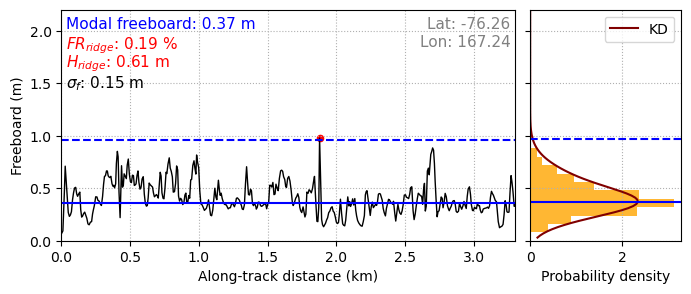

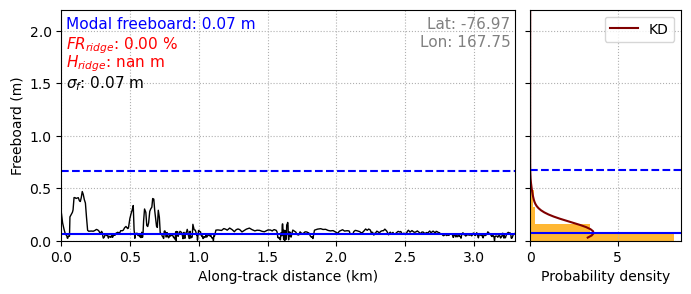

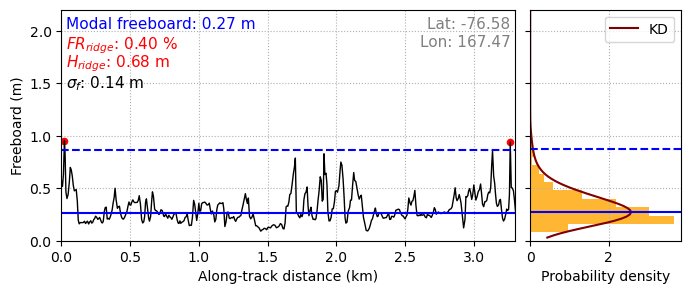

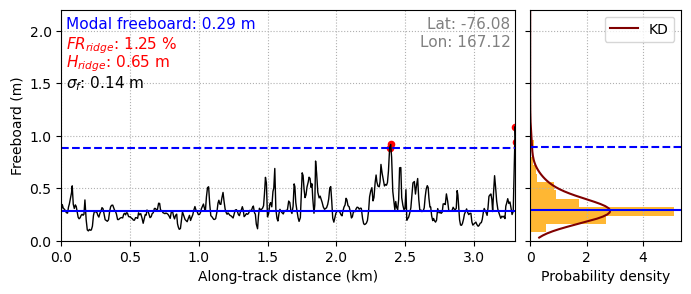

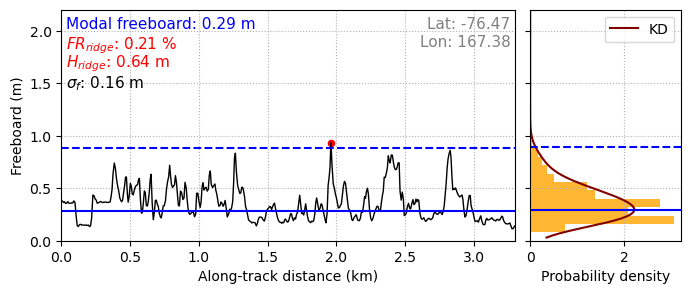

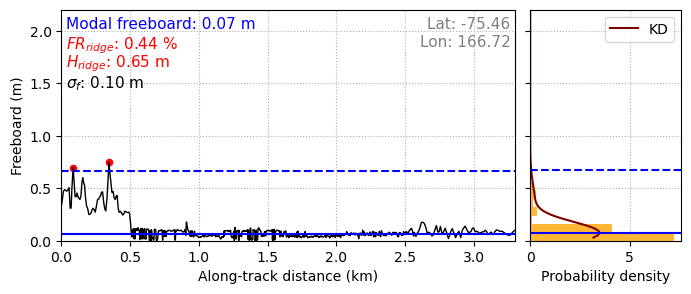

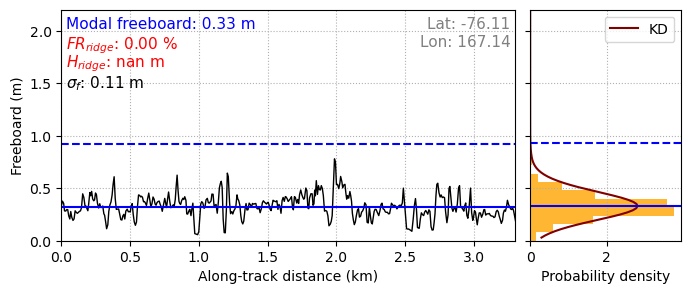

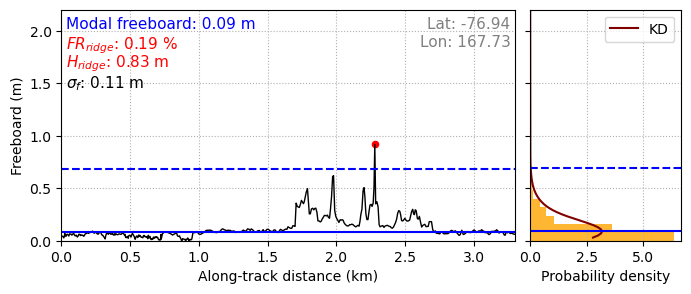

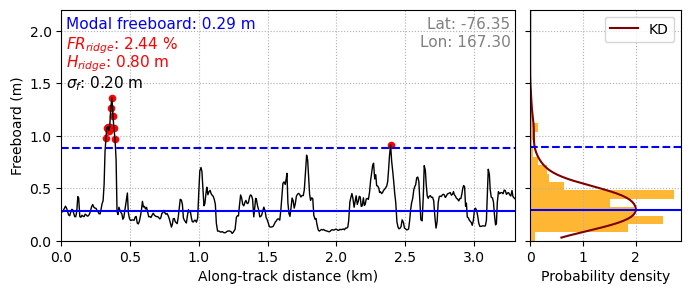

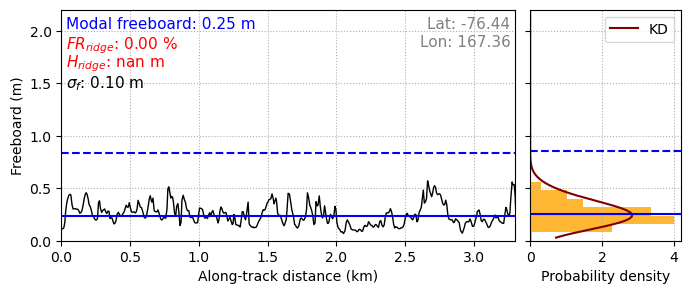

In [193]:
beam = 'gt2l'
for N in Ns:

    fig, ax = plt.subplots(1,2, figsize = (8, 3), dpi = 100, gridspec_kw={'width_ratios': [3, 1]}, sharey = True)
    plt.subplots_adjust(hspace=0.05, wspace=0.05)
    
    idx = (dF['beam'] == beam) & (dF['sample'] == N) # 140
    
    data = dF['freeboard'][idx].values
    x_d, logprob, mode = calculate_mode(data)
    
    idx_ridge = idx & (dF['ridge'] == 1)
    x_min = np.min(dF['seg_x'][idx]/1000)
    ax[0].plot(dF['seg_x'][idx]/1000 - x_min, dF['freeboard'][idx], color = 'k', lw = 1)
    ax[0].plot(dF['seg_x'][idx]/1000 - x_min, dF['fb_mode'][idx], color = "b")
    ax[0].plot(dF['seg_x'][idx]/1000 - x_min, dF['fb_mode'][idx] + 0.6, color = "b", ls = "--")
    ax[0].scatter(dF['seg_x'][idx_ridge]/1000 - x_min, dF['freeboard'][idx_ridge], color = "r", s = 20)
    ax[0].set_xlim(0, 3.3)
    ax[0].set_xlabel('Along-track distance (km)')
    ax[0].set_ylabel('Freeboard (m)')
    ax[0].grid(ls = ":", lw = 0.8)
    ax[0].annotate(f"Modal freeboard: {mode:.2f} m", xy = (0.01, 0.97), xycoords='axes fraction',
                   ha = "left", va = "top", fontsize = 11, color = "b")
    
    # ax[0].annotate(f"Mode: {mode}", xy = (0.01, 0.90), xycoords='axes fraction', ha = "left", va = "top", fontsize = 11)
    
    rf = np.sum(dF['seg_len'][idx_ridge]) / np.sum(dF['seg_len'][idx]) * 100
    rh = np.mean(dF['freeboard'][idx_ridge]) - mode
    sdf = np.std(dF['freeboard'][idx])
    pos_lat = np.mean(dF['lat'][idx])
    pos_lon = np.mean(dF['lon'][idx])
    
    ax[0].annotate("$FR_{ridge}$" + f": {rf:.2f} %", xy = (0.01, 0.89), xycoords='axes fraction',
                   ha = "left", va = "top", fontsize = 11, color = "r")
    ax[0].annotate("$H_{ridge}$" + f": {rh:.2f} m", xy = (0.01, 0.81), xycoords='axes fraction',
                   ha = "left", va = "top", fontsize = 11, color = "r")
    ax[0].annotate("$\sigma_{f}$" + f": {sdf:.2f} m", xy = (0.01, 0.72), xycoords='axes fraction',
                   ha = "left", va = "top", fontsize = 11, color = "k")

    ax[0].annotate("Lat" + f": {pos_lat:.2f}", xy = (0.99, 0.97), xycoords='axes fraction',
                   ha = "right", va = "top", fontsize = 11, color = "gray")
    ax[0].annotate("Lon" + f": {pos_lon:.2f}", xy = (0.99, 0.89), xycoords='axes fraction',
                   ha = "right", va = "top", fontsize = 11, color = "gray")
    
    ax[1].hist(data, density = True, range = (0,2), bins = 25, orientation = "horizontal", color = "orange", alpha = 0.8)
    ax[1].plot(np.exp(logprob), x_d + w/2, color = "maroon", label = "KD")
    ax[1].axhline(mode, color = "b")
    ax[1].axhline(mode + 0.6, color = "b", ls = "--")
    ax[1].set_ylim(0, 2.2)
    ax[1].set_xlabel('Probability density')
    ax[1].grid(ls = ":", lw = 0.8)
    ax[1].legend()

    prf_name = dF['filename'][0].replace('_006_01.h5', beam + str(int(N)) + ".png")
    plt.savefig("D:\\Ross\\Figures_profiles\\{0}.png".format(prf_name), bbox_inches="tight")

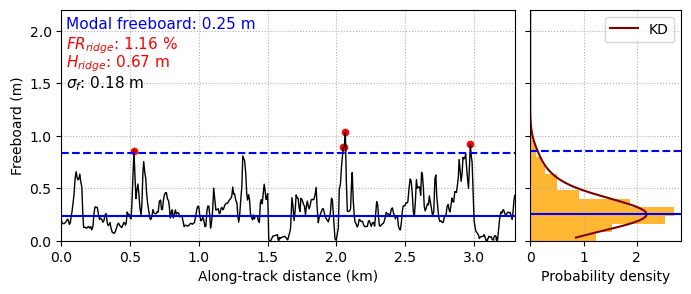

In [299]:
fig, ax = plt.subplots(1,2, figsize = (8, 3), dpi = 100, gridspec_kw={'width_ratios': [3, 1]}, sharey = True)
plt.subplots_adjust(hspace=0.05, wspace=0.05)

idx = (dF['beam'] == 'gt2l') & (dF['sample'] == 100) # 140

data = dF['freeboard'][idx].values
x_d, logprob, mode = calculate_mode(data)

idx_ridge = idx & (dF['ridge'] == 1)
x_min = np.min(dF['seg_x'][idx]/1000)
ax[0].plot(dF['seg_x'][idx]/1000 - x_min, dF['freeboard'][idx], color = 'k', lw = 1)
ax[0].plot(dF['seg_x'][idx]/1000 - x_min, dF['fb_mode'][idx], color = "b")
ax[0].plot(dF['seg_x'][idx]/1000 - x_min, dF['fb_mode'][idx] + 0.6, color = "b", ls = "--")
ax[0].scatter(dF['seg_x'][idx_ridge]/1000 - x_min, dF['freeboard'][idx_ridge], color = "r", s = 20)
ax[0].set_xlim(0, 3.3)
ax[0].set_xlabel('Along-track distance (km)')
ax[0].set_ylabel('Freeboard (m)')
ax[0].grid(ls = ":", lw = 0.8)
ax[0].annotate(f"Modal freeboard: {mode:.2f} m", xy = (0.01, 0.97), xycoords='axes fraction',
               ha = "left", va = "top", fontsize = 11, color = "b")

rf = np.sum(dF['seg_len'][idx_ridge]) / np.sum(dF['seg_len'][idx]) * 100
rh = np.mean(dF['freeboard'][idx_ridge]) - mode
sdf = np.std(dF['freeboard'][idx])

ax[0].annotate("$FR_{ridge}$" + f": {rf:.2f} %", xy = (0.01, 0.89), xycoords='axes fraction',
               ha = "left", va = "top", fontsize = 11, color = "r")
ax[0].annotate("$H_{ridge}$" + f": {rh:.2f} m", xy = (0.01, 0.81), xycoords='axes fraction',
               ha = "left", va = "top", fontsize = 11, color = "r")
ax[0].annotate("$\sigma_{f}$" + f": {sdf:.2f} m", xy = (0.01, 0.72), xycoords='axes fraction',
               ha = "left", va = "top", fontsize = 11, color = "k")

ax[1].hist(data, density = True, range = (0,2), bins = 25, orientation = "horizontal", color = "orange", alpha = 0.8)
ax[1].plot(np.exp(logprob), x_d + w/2, color = "maroon", label = "KD")
ax[1].axhline(mode, color = "b")
ax[1].axhline(mode + 0.6, color = "b", ls = "--")
ax[1].set_ylim(0, 2.2)
ax[1].set_xlabel('Probability density')
ax[1].grid(ls = ":", lw = 0.8)
ax[1].legend()

In [110]:
## Set-up projection for 4 sub-sectors =============================
inProj  = Proj("+init=EPSG:4326")
outProj = Proj("+init=EPSG:3412")
offset = 0.0

lons = np.concatenate((np.arange(168, 181), np.arange(-180, -171)))
lats = np.concatenate((np.ones(len(lons))*(-70+offset), np.ones(len(lons))*(-74+offset), np.array([-70+offset])))
lons = np.concatenate((lons, lons[::-1], np.array([168])))

NW_x, NW_y = transform(inProj,outProj,lons,lats)

lons = (np.arange(-172, -149))
lats = np.concatenate((np.ones(len(lons))*(-70+offset), np.ones(len(lons))*(-74+offset), np.array([-70+offset])))
lons = np.concatenate((lons, lons[::-1], np.array([-172])))

NE_x, NE_y = transform(inProj,outProj,lons,lats)

lons = np.concatenate((np.arange(162, 181), np.arange(-180, -171)))
lats = np.concatenate((np.ones(len(lons))*(-74+offset), np.ones(len(lons))*(-78+offset), np.array([-74+offset])))
lons = np.concatenate((lons, lons[::-1], np.array([162])))

SW_x, SW_y = transform(inProj,outProj,lons,lats)

lons = (np.arange(-172, -149))
lats = np.concatenate((np.ones(len(lons))*(-74+offset), np.ones(len(lons))*(-78+offset), np.array([-74+offset])))
lons = np.concatenate((lons, lons[::-1], np.array([-172])))

SE_x, SE_y = transform(inProj,outProj,lons,lats)
## ========================================================

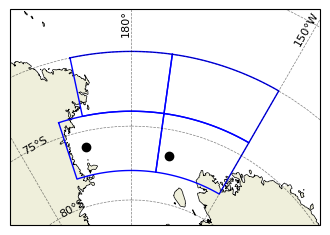

In [213]:
fig, ax = plt.subplots(1,1, figsize = (4,4), dpi= 100,
                       subplot_kw={'projection': ccrs.SouthPolarStereo(true_scale_latitude = -70)})
        
ax.coastlines('10m', linewidth = 0.5)
ax.add_feature(cfeature.LAND)

pos_lats = [-76.08, -76.74]
pos_lons = [167.12,-168.80]

pos_x, pos_y = transform(inProj,outProj,pos_lons,pos_lats)

ax.plot(NW_x, NW_y, lw=1, color = "b")
ax.plot(NE_x, NE_y, lw=1, color = "b")
ax.plot(SW_x, SW_y, lw=1, color = "b")
ax.plot(SE_x, SE_y, lw=1, color = "b")

ax.scatter(pos_x, pos_y, color = "k")

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                       xlocs = np.arange(-180, 180, 30), ylocs=  np.arange(-90, 90, 5),
                       linewidth=0.5, color='k', alpha = 0.5, linestyle='--')

# gl.xformatter = LONGITUDE_FORMATTER
# gl.yformatter = LATITUDE_FORMATTER
# gl.xlabel_style = {'size': 12, 'color': 'gray'}
gl.ylabel_style = {'size': 8, 'color': 'k', 'ha': 'left', 'va': 'bottom', 'rotation': 30}
gl.xlabel_style = {'size': 8, 'color': 'k', 'ha': 'center', 'rotation': 0}
gl.top_labels = False #False #False #False
gl.bottom_labels = False #False #False

ax.annotate('180°', xy=(0.39, 1.0), xycoords='axes fraction', rotation = 90, size = 8, va = 'top', ha ='right')
ax.annotate('150°W',xy=(1.0, 1.0), xycoords='axes fraction', rotation = 60, size = 8, va = 'top', ha ='right')


xmin, xmax = ax.set_xlim(900000, -1400000)
ymin, ymax = ax.set_ylim(-900000, -2500000)

In [132]:
len(x_d)

199

In [100]:
len(np.exp(logprob), density)

199

(0.0, 2.0)

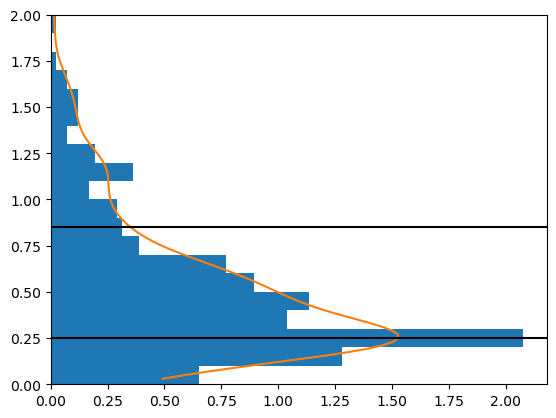

In [125]:
plt.hist(data, density = True, range = (0,2), bins = 20, orientation = "horizontal")
plt.plot(np.exp(logprob), x_d + w/2)
plt.axhline(mode, color = "k")
plt.axhline(mode + 0.6, color = "k")
plt.ylim(0, 2)

In [ ]:
# Calculate modal freeboard based on freeboard distribution
def calculate_mode(data, N = 20):
    data = data[~np.isnan(data)]
    w = 0.02
    M = 4
    m = w    
    
    if len(data) > N: # minimum number of freeboard observations to create distribution
        # instantiate and fit the KDE model
        kde = KernelDensity(bandwidth=w*5, kernel='gaussian')
        kde.fit(data[:, None])
        x_d = np.arange(m, M, w)
        logprob = kde.score_samples(x_d[:, None])
        n_max = np.argmax(np.exp(logprob))
        mode = x_d[n_max]
    # elif len(data) > 0: # if the number of observation is not enough, just take 0.4 quantile
    #     mode = np.quantile(data, 0.4)
    else:
        mode = np.nan

    return mode

## Read data

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4
from netCDF4 import Dataset    # Note: python is case-sensitive!
from netCDF4 import date2num,num2date
import datetime as dt
import cartopy.crs as ccrs

In [71]:
year = 2018

try: ncfile.close()  # just to be safe, make sure dataset is not already open.
except: pass


ncname = 'D:\\Ross\\ATL10_processed_nc\\Freeboard_ridges_density_2022.nc'.format(year)

with netCDF4.Dataset(ncname, 'r') as nc:
    keys = nc.variables.keys()
    fb_mode = np.array(nc.variables['fb_mode'])
    print(keys)

dict_keys(['x', 'y', 'time', 'lat', 'lon', 'fb_mode', 'fb_mean', 'fb_med', 'fb_std', 'fr_ridge', 'h_ridge', 'fr_lead'])


In [61]:
lat = np.array(nc.variables['lat'])
lon = np.array(nc.variables['lon'])
x = np.array(nc.variables['x'])
y = np.array(nc.variables['y'])
xx, yy = np.meshgrid(x, y)
np.shape(xx)

NW = (lat>-74) & (lat<-70) & ((lon<-172) | (lon>168))
SW = (lat>-78) & (lat<-74) & ((lon<-172) | (lon>168))
SE = (lat>-78) & (lat<-74) & ((lon<-150) & (lon>-172))
NE = (lat>-74) & (lat<-70) & ((lon<-150) & (lon>-172))

from pyproj import Proj, transform
inProj  = Proj("+init=EPSG:4326")
outProj = Proj("+init=EPSG:3031")

In [59]:
times = nc.variables['time']
times = num2date(times[:], units = times.units)

hours = np.array(nc.variables['time']).astype(float)
time_era = []

for i in range(0, len(hours)):
    time_era.append(dt.datetime(1800, 1, 1) + dt.timedelta(hours = hours[i]))

In [62]:
offset = 0.5

lons = np.concatenate((np.arange(168, 181), np.arange(-180, -171)))
lats = np.concatenate((np.ones(len(lons))*(-70+offset), np.ones(len(lons))*(-74+offset), np.array([-70+offset])))
lons = np.concatenate((lons, lons[::-1], np.array([168])))

NW_x, NW_y = transform(inProj,outProj,lons,lats)

lons = (np.arange(-172, -149))
lats = np.concatenate((np.ones(len(lons))*(-70+offset), np.ones(len(lons))*(-74+offset), np.array([-70+offset])))
lons = np.concatenate((lons, lons[::-1], np.array([-172])))

NE_x, NE_y = transform(inProj,outProj,lons,lats)

lons = np.concatenate((np.arange(162, 181), np.arange(-180, -171)))
lats = np.concatenate((np.ones(len(lons))*(-74+offset), np.ones(len(lons))*(-78+offset), np.array([-74+offset])))
lons = np.concatenate((lons, lons[::-1], np.array([162])))

SW_x, SW_y = transform(inProj,outProj,lons,lats)

lons = (np.arange(-172, -149))
lats = np.concatenate((np.ones(len(lons))*(-74+offset), np.ones(len(lons))*(-78+offset), np.array([-74+offset])))
lons = np.concatenate((lons, lons[::-1], np.array([-172])))

SE_x, SE_y = transform(inProj,outProj,lons,lats)

In [81]:
fb_mode.shape

(335, 141, 96)

In [88]:
year

2018

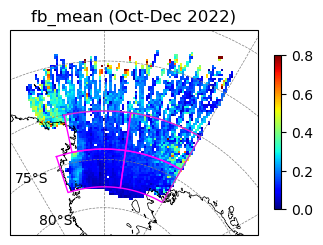

In [98]:
# Draw map ===========================================================

# date1 = [dt.datetime(year,3,1), dt.datetime(year,4,1), dt.datetime(year,5,1), dt.datetime(year,6,1),
#          dt.datetime(year,7,1), dt.datetime(year,8,1), dt.datetime(year,9,1), dt.datetime(year,10,1)]
# date2 = [dt.datetime(year,5,31), dt.datetime(year,6,30), dt.datetime(year,7,31), dt.datetime(year,8,31),
#          dt.datetime(year,9,30), dt.datetime(year,10,31), dt.datetime(year,11,30), dt.datetime(year,12,31)]

# date1 = [dt.datetime(year,4,1), dt.datetime(year,7,1), dt.datetime(year,10,1)]
# date2 = [dt.datetime(year,6,30), dt.datetime(year,9,30), dt.datetime(year,12,31)]

year = 2022
date1 = [dt.datetime(year,10,1)]
date2 = [dt.datetime(year,12,31)]

for i in range(0, len(date1)):
    
#     fig = plt.figure(figsize=(8,4), dpi= 100)
#     ax = plt.axes(projection=ccrs.SouthPolarStereo())

    fig, ax = plt.subplots(1, 1, figsize=(4,4), dpi= 100, subplot_kw={'projection': ccrs.SouthPolarStereo()})

    lons = np.arange(-180, -89)

    ax.coastlines('10m', linewidth = 0.5)
    
    ax.plot(NW_x, NW_y, lw=1, color = "magenta")
    ax.plot(NE_x, NE_y, lw=1, color = "magenta")
    ax.plot(SW_x, SW_y, lw=1, color = "magenta")
    ax.plot(SE_x, SE_y, lw=1, color = "magenta")

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, xlocs = np.arange(-180, 180, 30),
                      linewidth=0.5, color='grey', linestyle='--')
    
    gl.xlabels_top = False
    gl.xlabels_bottom = False
    gl.ylabels_left = False
    gl.ylabels_right = False
    
#     N = np.array(nc.variables['N'])
    
    tidx = (times >= date1[i]) & (times < date2[i])
    
    field1 = 'fb_mode'
    data1 = np.nanmean(fb_mode[tidx, :, :], axis = 0).transpose()
    
#     field2 = 'fb_mean'
#     data2 = np.nanmean((np.array(nc.variables[field2]))[tidx, :, :], axis = 0).transpose()
    
#     'fb_mean', 'fb_median', 'fb_std', 'fb_hist_freq', 'fb_hist_val', 'fr_ridge', 'h_ridge_mean', 'fr_lead', 'N'
    
    vmin, vmax = {}, {};
    vmin['fb_mode'] = 0.0; vmax['fb_mode'] = 0.5
    vmin['fb_mode1'] = 0.0; vmax['fb_mode1'] = 0.5
    vmin['fb_mode2'] = 0.0; vmax['fb_mode2'] = 0.5
    vmin['fr_ridge'] = 0.0; vmax['fr_ridge'] = 10
    vmin['fb_mean'] = 0.0; vmax['fb_mean'] = 0.8
    vmin['fb_median'] = 0.0; vmax['fb_median'] = 0.8
    vmin['fb_std'] = 0.0; vmax['fb_std'] = 0.5
    vmin['fr_lead'] = 0.0; vmax['fr_lead'] = 0.02
    vmin['h_ridge_mean'] = 0.6; vmax['h_ridge_mean'] = 1.0

    pm = ax.pcolormesh(xx, yy, data1,
                          cmap = "jet", vmin = vmin[field2], vmax = vmax[field2])

    xmin, xmax = ax.set_xlim(1100000, -1800000)
    ymin, ymax = ax.set_ylim(-800000, -3200000)
    
    ax.set_title("{0} ({1}-{2})".format(field2, date1[i].strftime("%b"), date2[i].strftime("%b %Y")),
                   fontsize = 12)
    
    plt.colorbar(pm, ax = ax, shrink = 0.5)
    # plt.savefig("F:\\2022_Ross\\Figures_map\\{0}_{1}-{2}.png".format(field2, date1[i].strftime("%Y%m"), date2[i].strftime("%Y%m")),
    #            bbox_inches="tight")

## Lead fractions